## Interactive Model Training 
Run the cells to reproduce the results

### Data and Models Used in Hisia

**Data:** 2016 TrustPilot's 254,464 Danish reviews' body and stars and [8 fake reviews]*20 see notes for explanation.<br>

**Models**<br>
Hisia, _LogisticRegression_ with SAGA, a variant of Stochastic Average Gradient (SAG) as solver, L2 penalty was select for base model. Test score **accurace is ca. 93%** and **recall of 93%**. SAGA it is faster solver for large datatsets(Rows and Columns). As stochastic gradient, memory of previous grdient is incorporated/feed-forward and thus achieve faster convergence rate. Seeds: 42 in data split, and 42 in model used for reproducibility.

HisiaTrain, _SGDClassifier_, Stochastic Gradient Descent learner with smooth loss 'modified_huber as loss function and L2 penalty. Test score **accurance  94%** and **recall of 94%**. SGDClassifier was select because of partial_fit. It allows batch/online training.

**Note:** This score reflects models in regards to TrustPilot reviews systle of writing.<b>
 >8*10 fake reviews. TrustPilot reviews are directed towards products and services. A word like 'elsker'(love) or 'hader'(hate) were rare. To make sure the model learns such relationship, I added 8 reviews and duplicated them 10 times. This new sentences did not increase or decrease the model accurance but added correct the coeffient of love, hate and (ikke dårligt) not bad. 

In [1]:
%reload_ext watermark
%watermark -uniz --author "Author Prayson W. Daniel" -vm -p pandas,numpy,matplotlib,scikit-learn,lemmy,dill

Author Prayson W. Daniel 
last updated: Wed Jun 03 2020 DST 2020-06-03T10:47:45+02:00

CPython 3.7.6
IPython 7.14.0

pandas 1.0.4
numpy 1.18.4
matplotlib 3.2.1
sklearn 0.23.1
lemmy 2.1.0
dill 0.3.1.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-17763-Microsoft
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [2]:
from collections import namedtuple
import joblib
import re
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
import lemmy

from helpers import show_diagram, show_most_informative_features

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight')

This stops were custom made from both unknown Danish stops words and products and services related words such as delivery, package, post office.

In [4]:
PATH_TO_DATA = '../data'
STOP_WORDS = joblib.load(f'{PATH_TO_DATA}/stops.pkl')

The tokenizer separates emojis from the words, removes digits, repetive words and stop words and lemmatize words

In [5]:
lemmatizer = lemmy.load('da')

def tokenizer(blob, stop_words=STOP_WORDS, remove_digits=True):
    
    if stop_words is None:
        stop_words = {}
    
    blob = blob.lower()
    
     # eyes [nose] mouth | mouth [nose] eyes pattern
    emoticons = r"(?:[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?)"
    emoticon_re = re.compile(emoticons, re.VERBOSE | re.I | re.UNICODE)
    
    text = re.sub(r'[\W]+', ' ', blob)
    
    # remove 3+ repetitive characters i.e. hellllo -> hello, jaaaa -> jaa 
    repetitions = re.compile(r'(.)\1{2,}')
    text = repetitions.sub(r'\1\1', text)
    
    # remove 2+ repetitive words e.g. hej hej hej -> hej
    
    repetitions = re.compile(r'\b(\w+)\s+(\1\s*)+\b')
    text = repetitions.sub(r'\1 ', text)
    
    
    # 14år --> 14 år
    text = re.sub(r'([0-9]+(\.[0-9]+)?)', r' \1 ', text).strip()
    
    emoji = ''.join(re.findall(emoticon_re, blob))
    
       
    # remove stopwords
    text_nostop = [word for word in text.split() if word not in stop_words]
    
    # tokenization lemmatize
    lemmatized_text = [lemmatizer.lemmatize('', word)[-1]  
                                 for word in text_nostop]
    
    remove_stopwords = ' '.join(word for word in lemmatized_text if len(word)>1)
    
    if remove_digits:
        remove_stopwords = re.sub(r'\b\d+\b', '', remove_stopwords)
    

    # remove extra spaces
    remove_stopwords = ' '.join(remove_stopwords .split())
    result = f'{remove_stopwords} {emoji}'.encode('utf-8').decode('utf-8')
       
    
    return result.split()

In [6]:
tokenizer('Jeg er vred på, at jeg ikke fik min pakke :(')

['vred', 'ikke', ':(']

In [7]:
df = pd.read_json(f'{PATH_TO_DATA}/data.json')

Fake reviews to teach our model the missing relationsh that is not found in TP reviews

In [8]:
dt = pd.DataFrame([('men elsker elsker', 1,5), 
                   ('elsker det ikke', 0, 1), 
                   ('ikke dårligt', 1, 5),
                   ('elsker skat, kæreste, tilbedte, dyrebare, elskling, darling, hjerte, hjertenskær; ven; veninde', 1, 5),
                   ('dårlig: syg, sløj, utilpas, ilde tilpas, upasselig, snavs, indisponeret;'
                    'sygelig, usund, ond, slet; arg, uheldig, umulig, elendig, under al kritik,'
                    'dødssyg, skidt, skral, krank, ussel, ikke noget at samle på, talentløs, uantagelig,'
                    'uacceptabel, forkastelig; ikke noget at råbe hurra for, ikke noget at skrive hjem om,'
                    'noget skidt (lort, pis), andenklasses, tredjeklasses (osv.), ringe, halvgod, ikke nogen'
                    'ørn til, ikke ens stærke side, ens svage punkt, som en brækket arm; sjusket; ufordelagtig,'
                    'ufyldestgørende, utilstrækkelig, utilfredsstillende, middelmådig, under lavmålet, uduelig,'
                    'udygtig, uhensigtsmæssig, forkert, tarvelig; skadelig, ødelæggende, fordærvet, ubrugelig;'
                    'ubehagelig, væmmelig, ulystbetonet; dys-; utiltalende, usympatisk, kedelig', 0, 1),
                    ('20.000 kroner. Det er, hvad man som arbejdstager burde få ekstra i lønningsposen,'
                    ' hvis man skal kunne acceptere at have en dårlig chef.', 0,1),
                   ('kærlighed, hvordan elsker vi hinanden godt – uanset hvem vi elsker?',1,5),
                   ('jeg hader dig', 0, 1),
                   
                  ]*20, 
                  columns='features target stars'.split())

In [9]:
# dt.to_json('../hisia/data/data_custom.json')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['features'], 
                                                     df['target'],
                                                     test_size=.2,
                                                     random_state=42,
                                                     stratify=df['target'])

In [11]:
X_train, y_train = X_train.append(dt['features'],ignore_index=True), y_train.append(dt['target'],ignore_index=True)

In [12]:
print(f'Traing Size: {X_train.shape[0]}\nTest Size: {X_test.shape[0]:>8}')
print(f'\nTraing Size\n\tPositive||Negative Samples\n\t  {y_train[y_train==1].shape[0]}||{y_train[y_train==0].shape[0]}')
print(f'\nTest Size\n\tPositive||Negative Samples\n\t  {y_test[y_test==1].shape[0]}||{y_test[y_test==0].shape[0]}')

Traing Size: 203731
Test Size:    50893

Traing Size
	Positive||Negative Samples
	  101866||101865

Test Size
	Positive||Negative Samples
	  25446||25447


In [13]:
hisia = Pipeline(steps =[
        ('count_verctorizer',  CountVectorizer(ngram_range=(1, 2), 
                                 max_features=150000,
                                 tokenizer=tokenizer, 
                                 #stop_words=STOP_WORDS
                                )
        ),
        ('feature_selector', SelectKBest(chi2, k=10000)),
        ('tfidf', TfidfTransformer(sublinear_tf=True)),
        ('logistic_regression', LogisticRegressionCV(cv=5,
                                                    solver='saga',
                                                    scoring='accuracy',
                                                    max_iter=200, 
                                                    n_jobs=-1,
                                                    random_state=42,
                                                    verbose=0))
])

In [14]:
%%time
hisia.fit(X_train, y_train)

/home/pwd/miniconda3/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pwd/miniconda3/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pwd/miniconda3/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pwd/miniconda3/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pwd/miniconda3/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model

CPU times: user 18min 28s, sys: 15.3 s, total: 18min 43s
Wall time: 7min 23s


Pipeline(steps=[('count_verctorizer',
                 CountVectorizer(max_features=150000, ngram_range=(1, 2),
                                 tokenizer=<function tokenizer at 0x7f299e7665f0>)),
                ('feature_selector',
                 SelectKBest(k=10000,
                             score_func=<function chi2 at 0x7f29a0f484d0>)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('logistic_regression',
                 LogisticRegressionCV(cv=5, max_iter=200, n_jobs=-1,
                                      random_state=42, scoring='accuracy',
                                      solver='saga'))])

In [15]:
hisia.score(X_test, y_test)

0.9400506945945415

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94     25447
    Positive       0.95      0.93      0.94     25446

    accuracy                           0.94     50893
   macro avg       0.94      0.94      0.94     50893
weighted avg       0.94      0.94      0.94     50893

	 _____________________________________________ 




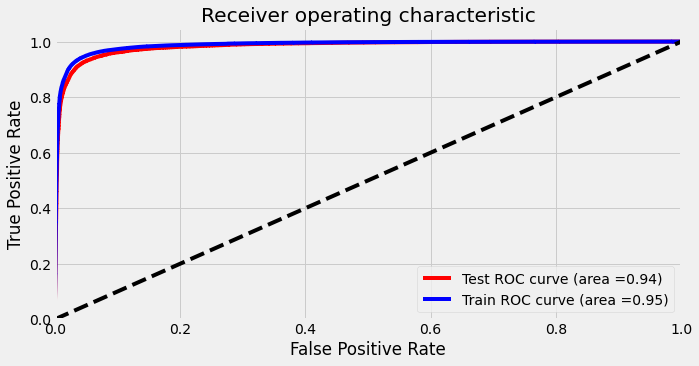

<Figure size 1080x360 with 0 Axes>

In [16]:
show_diagram(hisia, X_train, y_train, X_test, y_test, compare_test=True)

In [17]:
feature_names = hisia.named_steps['count_verctorizer'].get_feature_names()
best_features = [feature_names[i] for i in hisia.named_steps['feature_selector'].get_support(indices=True)]
predictor =  hisia.named_steps['logistic_regression']

In [18]:
N = 100
print(f'Showing {N} models learned features for negative and postive decisions')
print('_'*70)
print('\n')
show_most_informative_features(best_features, predictor, n=N)

Showing 100 models learned features for negative and postive decisions
______________________________________________________________________


	-9.5716	ikke orden     		8.9007	perfekt        
	-9.3119	dårlig         		8.1302	super          
	-9.1084	uacceptabel    		8.1070	god            
	-7.5375	elendig        		7.4784	fin            
	-7.5072	kilometer      		7.4612	nem            
	-6.9078	ikke ok        		7.2722	:-)            
	-6.8288	ikke anbefale  		7.1987	hurtig         
	-6.6592	ikke god       		6.7330	sidste stjerne 
	-6.1687	ikke modtage   		6.7021	tilfreds       
	-6.0957	ikke iorden    		6.6765	dejlig         
	-5.9087	ingen hjælpe   		6.4836	fantastisk     
	-5.8973	forkert        		6.4403	hurtigt        
	-5.8380	øv             		6.0026	fremragende    
	-5.7408	ikke tilfreds  		5.9886	ingen klage    
	-5.6898	opsige         		5.9668	ingen problem  
	-5.6738	umulig         		5.6523	:)             
	-5.6486	påstå          		5.3156	sætte finger   
	-5.4251	langsom       

In [19]:
hisia.predict_proba(['det er ikke okay!'])

array([[0.91904634, 0.08095366]])

In [20]:
hisia.predict_proba(['det er ikke dårligt!'])

array([[0.29335164, 0.70664836]])

In [21]:
hisia.predict_proba(['jeg elsker det!']), hisia.predict_proba(['jeg elsker det slet ikke!'])

(array([[0.15527274, 0.84472726]]), array([[0.72085339, 0.27914661]]))

In [22]:
mad_max = ['Jeg er vred på, at jeg ikke fik min pakke :( elsker']

In [23]:
hisia.named_steps['logistic_regression'].random_state

42

In [24]:
hisia.predict_proba([''])

array([[0.26974609, 0.73025391]])

In [25]:
hisia.predict(mad_max)

array([0])

In [26]:
res = hisia.predict_proba(mad_max)
res

array([[0.9267768, 0.0732232]])

In [27]:
hisia.decision_function(mad_max)

array([-2.53820046])

In [28]:
v = hisia.named_steps['count_verctorizer'].transform(mad_max)
v = hisia.named_steps['feature_selector'].transform(v)
v = pd.DataFrame.sparse.from_spmatrix(v)

In [29]:
v = set(v.loc[:,v.iloc[0]==1].columns)

In [30]:
look_up = {index:(token,coef) for index, coef, token in 
           zip(range(len(best_features)),
               hisia.named_steps['logistic_regression'].coef_[0], 
               best_features)}

In [31]:
{look_up[item] for item in v}

{(':(', -4.334440323513933),
 ('elsker', 0.6979194308004358),
 ('ikke', -3.425370797679455),
 ('vred', -2.012236087955754)}

In [32]:
hisia.named_steps['logistic_regression'].intercept_[0]

0.9959111721097562

In [33]:
g = [look_up[item] for item in v]

In [34]:
1/(1 + np.exp(-(g[0][1] + g[1][1] + hisia.named_steps['logistic_regression'].intercept_[0])))

0.15039067795765643

In [35]:
hisia.decision_function(mad_max)[0]

-2.538200460168757

In [36]:
df = pd.DataFrame(res)

In [37]:
df['sentiment'] = np.where(df[0] > .5, 'negative', 'positive')

In [38]:
df.columns = ['negative_probability','positive_probability','sentiment']

In [39]:
Sentiment = namedtuple('Sentiment', ['sentiment','positive_probability', 'negative_probability'])

In [40]:
df

,negative_probability,positive_probability,sentiment
0,0.926777,0.073223,negative


In [41]:
b = Sentiment(**df.round(3).to_dict(orient='index')[0])

In [42]:
b

Sentiment(sentiment='negative', positive_probability=0.073, negative_probability=0.927)

# Retrainable Model SGD

In [43]:
hisia_trainer =Pipeline(steps =[
                ('count_verctorizer',  CountVectorizer(ngram_range=(1, 2), 
                                         max_features=100000,
                                         tokenizer=tokenizer, 
                                        )
                ),
                ('feature_selector', SelectKBest(chi2, k=5000)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('modified_hubern', SGDClassifier(loss='modified_huber', 
                                                      random_state=7,
                                                      max_iter=1000))
])

In [44]:
%%time
hisia_trainer.fit(X_train, y_train)

CPU times: user 2min 12s, sys: 4.55 s, total: 2min 17s
Wall time: 2min 29s


Pipeline(steps=[('count_verctorizer',
                 CountVectorizer(max_features=100000, ngram_range=(1, 2),
                                 tokenizer=<function tokenizer at 0x7f299e7665f0>)),
                ('feature_selector',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x7f29a0f484d0>)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('modified_hubern',
                 SGDClassifier(loss='modified_huber', random_state=7))])

In [45]:
# for partil_fit we have to split the pipeline to transformation and scoring
hisia_trainer.score(X_test,y_test)

0.9352366730198652

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.92      0.95      0.94     25447
    Positive       0.95      0.92      0.93     25446

    accuracy                           0.94     50893
   macro avg       0.94      0.94      0.94     50893
weighted avg       0.94      0.94      0.94     50893

	 _____________________________________________ 




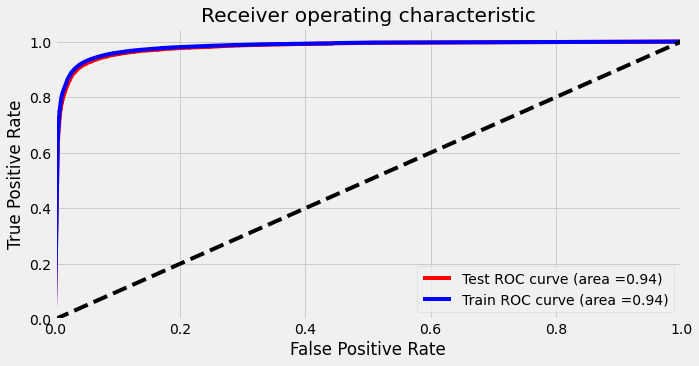

<Figure size 1080x360 with 0 Axes>

In [46]:
show_diagram(hisia_trainer, X_train, y_train, X_test, y_test, compare_test=True)

In [47]:
feature_names = hisia_trainer.named_steps['count_verctorizer'].get_feature_names()
best_features = [feature_names[i] for i in hisia_trainer.named_steps['feature_selector'].get_support(indices=True)]
predictor =  hisia_trainer.named_steps['modified_hubern']

In [48]:
N = 100
print(f'Showing {N} models learned features for negative and postive decisions')
print('_'*70)
print('\n')
show_most_informative_features(best_features, predictor, n=N)

Showing 100 models learned features for negative and postive decisions
______________________________________________________________________


	-2.5134	dårlig         		2.2176	god            
	-1.8454	ikke orden     		2.0373	hurtig         
	-1.7522	uacceptabel    		2.0333	super          
	-1.7472	elendig        		2.0238	perfekt        
	-1.6706	kilometer      		1.9283	nem            
	-1.6391	ikke god       		1.8499	fin            
	-1.6088	først          		1.8285	dejlig         
	-1.4937	forkert        		1.7523	:-)            
	-1.4503	langsom        		1.7110	tilfreds       
	-1.4139	ikke tilfreds  		1.6985	hurtigt        
	-1.3812	ikke modtage   		1.5544	fantastisk     
	-1.3790	betale         		1.4693	:)             
	-1.3671	øv             		1.2569	smile          
	-1.3622	forsøge        		1.2289	venlig         
	-1.3486	uge            		1.2043	ikke dårlig    
	-1.2826	ødelægge       		1.1629	fremragende    
	-1.2769	:-(            		1.1304	ingen problem  
	-1.2717	trætte        